ПРАКТИКУМ 5. АУГМЕНТАЦІЯ ДАНИХ ТА ПЕРЕНЕСЕННЯ НАВЧАННЯ

Загальні завдання для всіх варіантів:
1. Створіть власний унікальний набір навчальних зображень для згорткової
нейронної мережі. Набір має містити зображення як мінімум трьох різних
класів об’єктів. Всі зображення в наборі мають бути розподілені на три
підмножини – навчальну, валідаційну та тестову. Підмножини мають
розміщуватись у окремих папках. Використовувати готові набори з
попередніх робіт, які додаються до посібника (включно з усіма варіантами)
– заборонено!
2. Завантажте створений набір даних за допомогою генератора. Сформуйте
навчальну, валідаційну і тестову множини. Самостійно визначте
оптимальний розмір зображень та розмір батчу. Під час формування
навчальної множини використайте одну або декілька доступних опцій
генератора для аугментації даних.
3. Перевірте роботу генератора на довільному одному зображенні.
4. Використовуючи підхід transfer learning, створіть та навчіть згорткову
нейронну мережу на базі архітектури VGG-16 для розпізнавання класів
об’єктів на зображеннях. Побудуйте графік навчання.
5. Проведіть оцінку якості роботи навченої мережі на тестових даних.
6. Застосуйте навчену мережу для класифікації довільних зображень, які
імпортуються в програму з жорсткого диску ПК.
7. Спробуйте максимально покращити якість створеної нейронної мережі,
використавши тонкі налаштування (fine tuning).

In [ ]:
# 1. Імпорт бібліотек та налаштування
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import random


# Налаштування шляхів
# BASE_DIR = 'C:/HomeWork/bog/pw5/'
BASE_DIR = ''
DATA_DIR = os.path.join(BASE_DIR, "dataset_classification")
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# 2. Завантаження даних та Аугментація (Data Generators)
# Генератор для навчання з аугментацією
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Нормалізація пікселів (0-1)
    rotation_range=20,          # Випадковий поворот до 20 градусів
    width_shift_range=0.2,      # Зсув по ширині
    height_shift_range=0.2,     # Зсув по висоті
    shear_range=0.2,            # Зсув (shear)
    zoom_range=0.2,             # Наближення/віддалення
    horizontal_flip=True,       # Віддзеркалення
    fill_mode='nearest'         # Як заповнювати порожні пікселі
)

# Для валідації та тесту - ТІЛЬКИ рескейлінг (без викривлень)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Завантаження тренувальних даних:")
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("\nЗавантаження валідаційних даних:")
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("\nЗавантаження тестових даних:")
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"\nКласи: {class_names}")

Завантаження тренувальних даних:
Found 900 images belonging to 3 classes.

Завантаження валідаційних даних:
Found 134 images belonging to 3 classes.

Завантаження тестових даних:
Found 54 images belonging to 3 classes.

Класи: ['Inductor', 'LED-Light', 'Resistor']


In [ ]:
# 3. Створення моделі (Transfer Learning - VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 5. Навчання
EPOCHS = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/10
28/28 [==============================] - 68s 2s/step - loss: 0.8144 - accuracy: 0.7385 - val_loss: 0.1348 - val_accuracy: 0.9375
Epoch 2/10
28/28 [==============================] - 68s 2s/step - loss: 0.1984 - accuracy: 0.9205 - val_loss: 0.0345 - val_accuracy: 0.9922
Epoch 3/10
28/28 [==============================] - 67s 2s/step - loss: 0.1220 - accuracy: 0.9597 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 4/10
28/28 [==============================] - 43s 2s/step - loss: 0.1073 - accuracy: 0.9574 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 5/10
28/28 [==============================] - 15s 527ms/step - loss: 0.0823 - accuracy: 0.9677 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 6/10
28/28 [==============================] - 15s 535ms/step - loss: 0.0790 - accuracy: 0.9654 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 7/10
28/28 [==============================] - 32s 1s/step - loss: 0.0828 - accuracy: 0.9770 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 8/10
28/

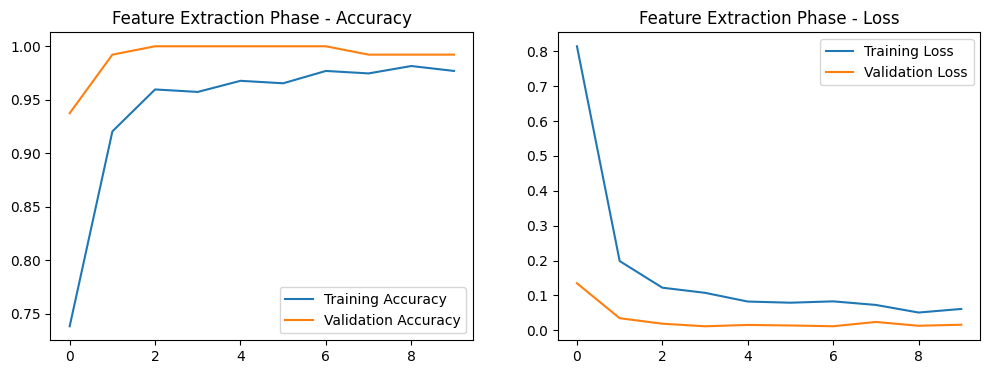

In [6]:
def plot_history(history, title="Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

plot_history(history, "Feature Extraction Phase")

In [7]:
# 6. Оцінка якості на тестових даних
print("Оцінка на тестовій вибірці...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Оцінка на тестовій вибірці...
2/2 [==============================] - 2s 917ms/step - loss: 0.0129 - accuracy: 1.0000

Test Accuracy: 100.00%
Test Loss: 0.0129


Початок Fine-Tuning...
Epoch 1/5
28/28 [==============================] - 59s 2s/step - loss: 0.0330 - accuracy: 0.9866 - val_loss: 0.0093 - val_accuracy: 0.9922
Epoch 2/5
28/28 [==============================] - 65s 2s/step - loss: 0.0329 - accuracy: 0.9873 - val_loss: 0.0178 - val_accuracy: 0.9844
Epoch 3/5
28/28 [==============================] - 59s 2s/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 4.1595e-04 - val_accuracy: 1.0000
Epoch 4/5
28/28 [==============================] - 58s 2s/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 4.5245e-04 - val_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 56s 2s/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.0011 - val_accuracy: 1.0000


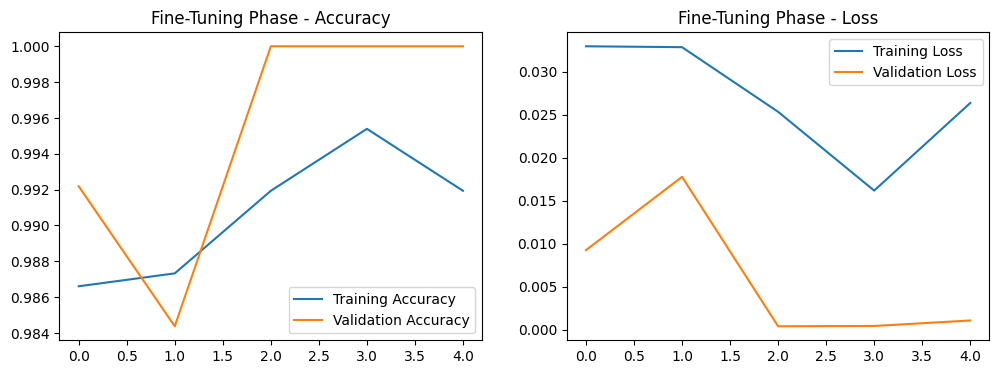

In [ ]:
# 7. Fine-Tuning (Тонке налаштування)
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), # Дуже малий крок
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Початок Fine-Tuning...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5, # Додаткові епохи
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

plot_history(history_fine, "Fine-Tuning Phase")

In [ ]:
# 8. Збереження та завантаження моделі (Bonus)
MODEL_PATH = os.path.join(BASE_DIR, 'electro_components_vgg16.keras')

model.save(MODEL_PATH)
print(f"Модель збережено у: {MODEL_PATH}")

Модель збережено у: C:/HomeWork/bog/pw5/electro_components_vgg16.keras


In [ ]:
# Завантажена моделі якщо вона ще не завантажена
if not 'model' in globals():
    print("Завантаження моделі...")
    model = load_model(MODEL_PATH)
    
    print("Перевірка завантаженої моделі на тестових даних:")
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"Loaded Model Accuracy: {acc*100:.2f}%")

In [ ]:
# Класифікація довільного зображення
def predict_custom_image(image_path, model, class_names):
    print(f'{image_path = }')
    if not os.path.exists(image_path):
        print("Файл не знайдено!")
        return

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = img_array / 255.0

    # Прогноз
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    predicted_class = class_names[np.argmax(predictions)]
    confidence = 100 * np.max(predictions)

    # Вивід
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

def get_random_img():
    global IMAGES_TEST_CACHE
    
    if not IMAGES_TEST_CACHE:
        print("💾 Сканування папки test...")
        test_dir = os.path.join(DATA_DIR, 'test')
        
        for class_name in os.listdir(test_dir):
            class_path = os.path.join(test_dir, class_name)
            
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        full_path = os.path.join(class_path, file_name)
                        IMAGES_TEST_CACHE.append(full_path)
        
        print(f"✅ Закешовано {len(IMAGES_TEST_CACHE)} файлів.")

    if not IMAGES_TEST_CACHE:
        print("Помилка: Не знайдено жодного зображення!")
        return None

    # Повертаємо випадкове фото з повного списку
    return random.choice(IMAGES_TEST_CACHE)

💾 Сканування папки test...
✅ Закешовано 54 файлів.
image_path = 'C:/HomeWork/bog/pw5/dataset_classification\\test\\Inductor\\Inductor_122.jpg'
1/1 [==============================] - 0s 113ms/step


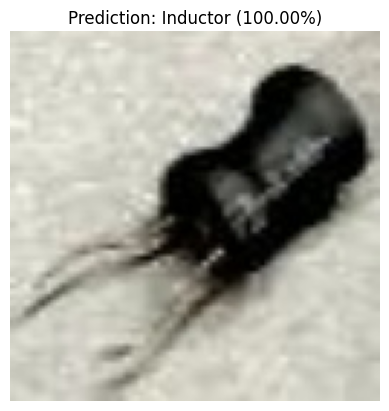

In [23]:
predict_custom_image(get_random_img(), model, class_names)

image_path = 'C:/HomeWork/bog/pw5/dataset_classification\\test\\LED-Light\\LED-Light_754.jpg'
1/1 [==============================] - 0s 48ms/step


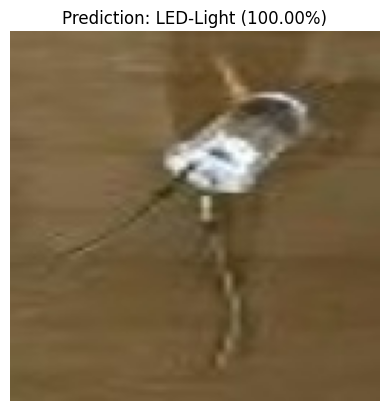

In [24]:
predict_custom_image(get_random_img(), model, class_names)


---

In [ ]:
# Передобробка датасету
def pre_process_dataset():
    import os
    import cv2
    import random
    import shutil
    import numpy as np

    # --- НАЛАШТУВАННЯ ---
    BASE_DIR = 'C:/HomeWork/bog/pw5/'
    IMG_SIZE = (128, 128)
    MIN_SAMPLES = 300
    OUTPUT_DIR = os.path.join(BASE_DIR, "dataset_classification")

    ALL_CLASSES = [
        '1-5-Volt-Battery', '3-3-Volt-Battery', '7-Segment-Display', '9-Volt-Battery', 
        'Arduino-Mega', 'Arduino-Nano', 'Arduino-Uno', 'BJT-Transistor', 'Bluetooth-Module', 
        'Breadboard', 'Bridge-Rectifier', 'Buck-Converter', 'Buzzer', 'Capacitor-10mf', 
        'Capacitor-470mf', 'DC-Motor', 'Diode', 'ESP32', 'ESP32-CAM', 'FT-232-USB-Serial-Module', 
        'Film-Capacitor', 'Fuse', 'Fuse-Base', 'GSM-Module', 'Gas-Sensor', 'Heat-Sink', 
        'High-Voltage-Ceramic-Capacitor', 'Humidity-Sensor', 'IC-Base-14-Pin', 'IC-Base-28-Pin', 
        'IC-Chip', 'IGBT', 'IR-Sensor', 'Inductor', 'Keypad', 'LCD-Display', 'LDR-Sensor', 
        'LED-Light', 'Low-Voltage-Ceramic-Capacitor', 'MLC-Capacitor', 'MOSFET', 'Motion-Sensor', 
        'Motor-Driver', 'NTC-Thermistor', 'OLED-Display', 'Pin-Header', 'Push-Switch', 
        'RFID-Scanner', 'Raindrops-Module', 'Relay-Module', 'Resistor', 'Rocker-Switch', 
        'Servo-Motor', 'Soil-Moisture-Sensor', 'Sonar-Sensor', 'TCRT5000', 'Tact-Switch', 
        'Taper-Potentiometer', 'Trimmer-Potentiometer', 'Water-Sensor', 'Zener-Diode'
    ]
    
    TARGET_CLASSES = ['Resistor', 'LED-Light', 'Inductor'] 
    SPLIT_RATIO = {"train": 0.7, "val": 0.2, "test": 0.1}

    # --- ФУНКЦІЇ ---

    def create_dirs():
        if os.path.exists(OUTPUT_DIR):
            shutil.rmtree(OUTPUT_DIR)
        for split in ["train", "val", "test"]:
            for cls_name in TARGET_CLASSES:
                os.makedirs(os.path.join(OUTPUT_DIR, split, cls_name), exist_ok=True)

    def yolo_to_pixels(x_c, y_c, w, h, img_w, img_h):
        x_c, y_c, w, h = float(x_c), float(y_c), float(w), float(h)
        width = w * img_w
        height = h * img_h
        x_min = int((x_c * img_w) - (width / 2))
        y_min = int((y_c * img_h) - (height / 2))
        x_max = int(x_min + width)
        y_max = int(y_min + height)
        return max(0, x_min), max(0, y_min), min(img_w, x_max), min(img_h, y_max)

    def augment_image(img):
        """Повертає випадково змінену версію зображення"""
        actions = {
            'rot90':  lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
            'rot180': lambda x: cv2.rotate(x, cv2.ROTATE_180),
            'rot270': lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
            'flipH':  lambda x: cv2.flip(x, 1),
            'flipV':  lambda x: cv2.flip(x, 0),
            'bright': lambda x: cv2.convertScaleAbs(x, alpha=1, beta=30),
            'dark':   lambda x: cv2.convertScaleAbs(x, alpha=1, beta=-30),
            'noise':  lambda x: cv2.add(x, np.random.normal(0, 15, x.shape).astype(np.uint8))
        }
        op_name = random.choice(list(actions.keys()))
        return actions[op_name](img)

    def balance_train_data():
        print("\n--- Починаємо балансування (аугментацію) даних ---")
        train_dir = os.path.join(OUTPUT_DIR, "train")
        
        for cls_name in TARGET_CLASSES:
            cls_path = os.path.join(train_dir, cls_name)
            if not os.path.exists(cls_path): continue

            existing_files = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png'))]
            count = len(existing_files)
            
            if count == 0: continue

            if count < MIN_SAMPLES:
                needed = MIN_SAMPLES - count
                print(f"Клас '{cls_name}': {count} -> +{needed} нових...")
                
                for i in range(needed):
                    src_file = random.choice(existing_files)
                    src_img = cv2.imread(os.path.join(cls_path, src_file))
                    if src_img is None: continue
                    
                    aug_img = augment_image(src_img)
                    
                    cv2.imwrite(os.path.join(cls_path, f"aug_{i}_{src_file}"), aug_img)
            else:
                print(f"Клас '{cls_name}': {count} (OK).")

    def process_dataset():
        create_dirs()
        target_ids = [ALL_CLASSES.index(name) for name in TARGET_CLASSES]
        
        print(f"Етап 1: Нарізка зображень...")
        processed_count = 0

        for FOLDER in ('test', 'valid', 'train'):
            PATH_TO_IMAGES = os.path.join(BASE_DIR, "dataset", FOLDER, "images")
            PATH_TO_LABELS = os.path.join(BASE_DIR, "dataset", FOLDER, "labels")
            if not os.path.exists(PATH_TO_LABELS): continue

            files = [f for f in os.listdir(PATH_TO_LABELS) if f.endswith('.txt')]
            for txt_file in files:
                base_name = os.path.splitext(txt_file)[0]
                img_path = os.path.join(PATH_TO_IMAGES, base_name + ".jpg")
                if not os.path.exists(img_path):
                    img_path = os.path.join(PATH_TO_IMAGES, base_name + ".png")
                    if not os.path.exists(img_path): continue

                img = cv2.imread(img_path)
                if img is None: continue
                img_h, img_w = img.shape[:2]

                with open(os.path.join(PATH_TO_LABELS, txt_file), 'r') as f:
                    lines = f.readlines()

                for line in lines:
                    parts = line.strip().split()
                    try: class_id = int(parts[0])
                    except ValueError: continue

                    if class_id in target_ids:
                        class_name = ALL_CLASSES[class_id]
                        x1, y1, x2, y2 = yolo_to_pixels(parts[1], parts[2], parts[3], parts[4], img_w, img_h)
                        crop = img[y1:y2, x1:x2]
                        if crop.size == 0: continue

                        try: crop_resized = cv2.resize(crop, IMG_SIZE)
                        except Exception: continue

                        rand = random.random()
                        if rand < SPLIT_RATIO["train"]: split_folder = "train"
                        elif rand < SPLIT_RATIO["train"] + SPLIT_RATIO["val"]: split_folder = "val"
                        else: split_folder = "test"

                        file_name = f"{class_name}_{processed_count}.jpg"
                        save_path = os.path.join(OUTPUT_DIR, split_folder, class_name, file_name)
                        cv2.imwrite(save_path, crop_resized)
                        processed_count += 1
        
        print(f"Нарізка завершена. Всього файлів: {processed_count}")
        balance_train_data()
        print("Роботу завершено!")

    process_dataset()

# pre_process_dataset
# Етап 1: Нарізка зображень...
# Нарізка завершена. Всього файлів: 755
# --- Починаємо балансування (аугментацію) даних ---
# Клас 'Resistor': 126 -> +174 нових...
# Клас 'LED-Light': 224 -> +76 нових...
# Клас 'Inductor': 217 -> +83 нових...
# Роботу завершено!